# Task 1: Graph binary Classification with GNNs
## Binary Classification on PROTEINS Dataset

This notebook implements a Graph Neural Network for binary classifica|tion using the PROTEINS citation network dataset.

## 1. Setup & Reproducibility

In [ ]:
# Install dependencies
!pip install torch torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 324.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch_geometric.transforms as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import random
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")


Using device: cuda
PyTorch version: 2.8.0+cu126


## 2. Data Loading & Preprocessing

In [ ]:
# Load Cora dataset
# Cora is chosen because it's a classic citation network with good class balance
# and represents real-world academic paper relationships
dataset = TUDataset(root='data/TUDataset', name='PROTEINS', transform=NormalizeFeatures())
data = dataset[0].to(device)

print("=== Dataset Information ===")
print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

# Analyze class distribution
print(f"\n=== Class Distribution ===")
labels = [graph.y.item() for graph in dataset]
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Class {int(label)}: {count} graphs ({count/len(dataset)*100:.1f}%)")


# Analyze train/val/test splits
dataset = dataset.shuffle()
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:train_size + val_size]
test_dataset = dataset[train_size + val_size:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\n=== Data Splits ===")
print(f"Training graphs: {len(train_dataset)}")
print(f"Validation graphs: {len(val_dataset)}")
print(f"Test graphs: {len(test_dataset)}")

Processing...
Done!


=== Dataset Information ===
Dataset: PROTEINS(1113)
Number of graphs: 1113
Number of features: 3
Number of classes: 2

=== Class Distribution ===
Class 0: 663 graphs (59.6%)
Class 1: 450 graphs (40.4%)

=== Data Splits ===
Training graphs: 890
Validation graphs: 111
Test graphs: 112


## 3. Baseline Model

In [ ]:
# Function to extract graph-level features and labels from a DataLoader
def extract_graph_features(loader):
    all_features = []
    all_labels = []
    for data in loader:
        # Assuming you want to use the mean of node features as a simple graph feature
        # This aggregates node features for each graph in the batch
        features = global_mean_pool(data.x, data.batch)
        all_features.append(features)
        all_labels.append(data.y)
    return torch.cat(all_features, dim=0), torch.cat(all_labels, dim=0)

# --- Baseline Model Training and Evaluation ---

class BaselineModel:
    """Simple logistic regression baseline using aggregated graph features"""

    def __init__(self):
        self.model = LogisticRegression(max_iter=1000, random_state=42)
        self.scaler = StandardScaler()

    def train(self, X_train, y_train):
        # Scale features and train the model
        X_train_scaled = self.scaler.fit_transform(X_train.cpu().numpy())
        self.model.fit(X_train_scaled, y_train.cpu().numpy())

    def predict(self, X):
        # Scale features and make predictions
        X_scaled = self.scaler.transform(X.cpu().numpy())
        return torch.tensor(self.model.predict(X_scaled))

    def predict_proba(self, X):
        # Scale features and predict probabilities
        X_scaled = self.scaler.transform(X.cpu().numpy())
        return torch.tensor(self.model.predict_proba(X_scaled))

# Extract graph features for training and testing
print("=== Extracting Graph Features for Baseline ===")
X_train_graphs, y_train_graphs = extract_graph_features(train_loader)
X_test_graphs, y_test_graphs = extract_graph_features(test_loader)

# Train baseline model
print("=== Training Baseline Model ===")
baseline = BaselineModel()
baseline.train(X_train_graphs, y_train_graphs)

# Evaluate baseline
baseline_pred = baseline.predict(X_test_graphs)
baseline_acc = accuracy_score(y_test_graphs.cpu(), baseline_pred)
baseline_f1 = f1_score(y_test_graphs.cpu(), baseline_pred, average='macro')
baseline_cm = confusion_matrix(y_test_graphs.cpu(), baseline_pred)

print(f"\n=== Baseline Results ===")
print(f"Baseline Test Accuracy: {baseline_acc:.4f}")
print(f"Baseline Test Macro F1: {baseline_f1:.4f}")
print("\nConfusion Matrix:")
print(baseline_cm)

=== Extracting Graph Features for Baseline ===
=== Training Baseline Model ===

=== Baseline Results ===
Baseline Test Accuracy: 0.7143
Baseline Test Macro F1: 0.5475

Confusion Matrix:
[[74  2]
 [30  6]]


## 4. GNN Models (GCN & GAT Architectures + Implementation)

### 4.1 Graph Convolutional Network (GCN)

**Architecture Choice:** Graph Convolutional Network (GCN)  

**Rationale:**
- **Simplicity & Interpretability**: Based on spectral graph theory, GCN is mathematically grounded and easy to interpret.  
- **Homophilic Graphs**: Works best when connected nodes share similar labels (e.g., citation networks).  
- **Efficiency**: Scales linearly with number of edges, suitable for medium-sized datasets.  
- **Baseline Strength**: Common and proven benchmark model in graph learning.  

**Architecture Details:**
- **Layers**: 2 × GCNConv  
- **Hidden Dimension**: 64  
- **Activation**: ReLU after each convolution  
- **Dropout**: 0.5 (applied after first convolution)  
- **Pooling**: Global mean pooling for graph-level representation  
- **Classifier**: Fully connected linear layer → log-softmax output  

---

### 4.2 Graph Attention Network (GAT)

**Architecture Choice:** Graph Attention Network (GAT)  

**Rationale:**
- **Attention Mechanism**: Learns importance weights for neighbors instead of uniform averaging.  
- **Expressive Power**: Can handle heterophilic and more complex relational graphs.  
- **Multi-head Attention**: Increases model stability and representation diversity.  
- **State-of-the-art**: Frequently outperforms GCNs on citation and biological datasets.  

**Architecture Details:**
- **Layers**:  
  - Layer 1: GATConv with 8 heads → hidden_dim × 8  
  - Layer 2: GATConv → hidden_dim (64)  
- **Activation**: ReLU after each convolution  
- **Dropout**: 0.5 (applied after first convolution)  
- **Pooling**: Global mean pooling for graph-level representation  
- **Classifier**: Fully connected linear layer → log-softmax output  

---

### 4.3 Implementation Notes

- Both models are implemented in **PyTorch Geometric (PyG)**.  
- Hidden dimension: **64** for a balance between expressiveness and regularization.  
- Models initialized with `dataset.num_features` as input dimension and `dataset.num_classes` as output dimension.  
- Comparison of parameter counts is printed to understand complexity differences:  
  - **GCN Parameters**: `sum(p.numel() for p in gcn_model.parameters())`  
  - **GAT Parameters**: `sum(p.numel() for p in gat_model.parameters())`  

---


In [ ]:
# Define a simple configuration class for hyperparameters
class Config:
    dropout_rate = 0.5
    heads = 8

config = Config()

class GCNGraphClassifier(nn.Module):
    """Graph Convolutional Network for graph classification"""
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=config.dropout_rate):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()

        # 2. Readout layer (global mean pooling)
        x = global_mean_pool(x, batch)

        # 3. Classifier
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

class GATGraphClassifier(nn.Module):
    """Graph Attention Network for graph classification"""
    def __init__(self, input_dim, hidden_dim, output_dim, heads=config.heads, dropout_rate=config.dropout_rate):
        super().__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# Initialize models
gcn_model = GCNGraphClassifier(
    input_dim=dataset.num_features,
    hidden_dim=64,
    output_dim=dataset.num_classes
).to(device)

gat_model = GATGraphClassifier(
    input_dim=dataset.num_features,
    hidden_dim=64,
    output_dim=dataset.num_classes
).to(device)

print("\n=== Model Architectures ===")
print(f"GCN: {gcn_model}")
print(f"GAT: {gat_model}")
print(f"GCN Parameters: {sum(p.numel() for p in gcn_model.parameters())}")
print(f"GAT Parameters: {sum(p.numel() for p in gat_model.parameters())}")


=== Model Architectures ===
GCN: GCNGraphClassifier(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (classifier): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
GAT: GATGraphClassifier(
  (conv1): GATConv(3, 64, heads=8)
  (conv2): GATConv(512, 64, heads=1)
  (classifier): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
GCN Parameters: 4546
GAT Parameters: 36162


## 5. Training & Evaluation with and without data augmentation

In [ ]:
def train_model(model, train_loader, val_loader, epochs=200, lr=0.01, weight_decay=5e-4):
    """Train a GNN graph classification model with early stopping"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0
    patience_counter = 0
    patience = 20
    history = {'train_losses': [], 'val_losses': [], 'train_accs': [], 'val_accs': []}
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train_nodes = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            pred = out.argmax(dim=1)
            correct_train += int((pred == data.y).sum())
            total_train_nodes += data.num_graphs
        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = correct_train / total_train_nodes
        history['train_losses'].append(avg_train_loss)
        history['train_accs'].append(train_acc)
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val_nodes = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data.x, data.edge_index, data.batch)
                loss = F.nll_loss(out, data.y)
                total_val_loss += loss.item()
                pred = out.argmax(dim=1)
                correct_val += int((pred == data.y).sum())
                total_val_nodes += data.num_graphs
            avg_val_loss = total_val_loss / len(val_loader)
            val_acc = correct_val / total_val_nodes
            history['val_losses'].append(avg_val_loss)
            history['val_accs'].append(val_acc)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
        if epoch % 50 == 0:
            print(f'Epoch {epoch:03d}, Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    model.load_state_dict(torch.load('best_model.pth'))
    history['best_val_acc'] = best_val_acc
    return history


def evaluate_model(model, loader, model_name="Model"):
    """Comprehensive model evaluation on test set"""
    model.eval()
    all_preds, all_labels = [], []
    correct = 0
    total_graphs = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total_graphs += data.num_graphs
            all_preds.extend(pred.cpu().tolist())
            all_labels.extend(data.y.cpu().tolist())
    acc = correct / total_graphs
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    print(f"\n=== {model_name} Results ===")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Macro F1: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    return acc, f1, np.array(all_preds), cm


In [ ]:
# Data augmentation functions
def node_dropping(data, drop_prob=0.1):
    num_nodes = data.x.size(0)
    keep_mask = torch.rand(num_nodes) > drop_prob
    if keep_mask.sum() == 0:
        keep_mask[random.randint(0, num_nodes - 1)] = True
    new_x = data.x[keep_mask]
    node_mapping = torch.cumsum(keep_mask, dim=0) - 1
    row, col = data.edge_index
    edge_mask = keep_mask[row] & keep_mask[col]
    new_edge_index = torch.stack([
        node_mapping[row[edge_mask]],
        node_mapping[col[edge_mask]]
    ], dim=0)
    return Data(x=new_x, edge_index=new_edge_index, y=data.y)

def random_walk_subgraph(data, walk_length=20, start_node=None):
    num_nodes = data.x.size(0)
    if start_node is None:
        start_node = random.randint(0, num_nodes - 1)
    current_node = start_node
    visited_nodes = [current_node]
    for _ in range(walk_length - 1):
        neighbors = []
        row, col = data.edge_index
        neighbors = col[row == current_node].tolist()
        neighbors += row[col == current_node].tolist()
        neighbors = list(set(neighbors))
        if current_node in neighbors:
            neighbors.remove(current_node)
        if not neighbors:
            break
        current_node = random.choice(neighbors)
        visited_nodes.append(current_node)
    visited_nodes = list(set(visited_nodes))
    visited_nodes.sort()
    node_mask = torch.zeros(num_nodes, dtype=torch.bool)
    node_mask[visited_nodes] = True
    node_mapping = torch.zeros(num_nodes, dtype=torch.long)
    node_mapping[node_mask] = torch.arange(len(visited_nodes))
    new_x = data.x[node_mask]
    row, col = data.edge_index
    edge_mask = node_mask[row] & node_mask[col]
    new_edge_index = torch.stack([
        node_mapping[row[edge_mask]],
        node_mapping[col[edge_mask]]
    ], dim=0)
    return Data(x=new_x, edge_index=new_edge_index, y=data.y)

def edge_perturbation(data, perturb_prob=0.1):
    num_edges = data.edge_index.size(1)
    perturb_num = int(perturb_prob * num_edges)
    if perturb_num == 0:
        return data
    edge_mask = torch.ones(num_edges, dtype=torch.bool)
    remove_indices = torch.randperm(num_edges)[:perturb_num]
    edge_mask[remove_indices] = False
    new_edges = []
    num_nodes = data.x.size(0)
    for _ in range(perturb_num):
        if random.random() < 0.5:
            src = random.randint(0, num_nodes - 1)
            dst = random.randint(0, num_nodes - 1)
            new_edges.append([src, dst])
    if new_edges:
        new_edge_index = torch.tensor(new_edges, dtype=torch.long).t().contiguous()
        new_edge_index = torch.cat([data.edge_index[:, edge_mask], new_edge_index], dim=1)
    else:
        new_edge_index = data.edge_index[:, edge_mask]
    return Data(x=data.x, edge_index=new_edge_index, y=data.y)

def feature_masking(data, mask_prob=0.1):
    if mask_prob == 0:
        return data
    new_x = data.x.clone()
    mask = torch.rand_like(new_x) < mask_prob
    new_x[mask] = 0
    return Data(x=new_x, edge_index=data.edge_index, y=data.y)

def k_hop_subgraph(data, k=2, center_node=None):
    num_nodes = data.x.size(0)
    if center_node is None:
        center_node = random.randint(0, num_nodes - 1)
    neighbors = set([center_node])
    current_level = set([center_node])
    for _ in range(k):
        next_level = set()
        for node in current_level:
            row, col = data.edge_index
            node_neighbors = col[row == node].tolist()
            node_neighbors += row[col == node].tolist()
            next_level.update(node_neighbors)
        neighbors.update(next_level)
        current_level = next_level - neighbors
    visited_nodes = list(neighbors)
    visited_nodes.sort()
    node_mask = torch.zeros(num_nodes, dtype=torch.bool)
    node_mask[visited_nodes] = True
    node_mapping = torch.zeros(num_nodes, dtype=torch.long)
    node_mapping[node_mask] = torch.arange(len(visited_nodes))
    new_x = data.x[node_mask]
    row, col = data.edge_index
    edge_mask = node_mask[row] & node_mask[col]
    new_edge_index = torch.stack([
        node_mapping[row[edge_mask]],
        node_mapping[col[edge_mask]]
    ], dim=0)
    return Data(x=new_x, edge_index=new_edge_index, y=data.y)

def augment_dataset(dataset, augmentation_type):
    augmented_dataset = []

    # Map string to function
    aug_map = {
        'node_drop': node_dropping,
        'random_walk': random_walk_subgraph,
        'edge_perturb': edge_perturbation,
        'feature_mask': feature_masking,
        'k_hop': k_hop_subgraph
    }

    aug_func = aug_map[augmentation_type]

    for graph in dataset:
        augmented_graph = aug_func(graph)
        augmented_dataset.append(augmented_graph)

    return augmented_dataset

## Without augmentation

In [ ]:
# --- Comparative Study with and without All Augmentation Techniques ---
print("\n\n=== Comparative Study: with and without Augmentation Techniques ===")

# Store all results
all_results = []

# --- Run Baseline Models ---
# Train and evaluate GCN (no aug)
gcn_model = GCNGraphClassifier(input_dim=dataset.num_features, hidden_dim=64, output_dim=dataset.num_classes).to(device)
print("\n=== Training GCN Baseline ===")
gcn_history = train_model(gcn_model, train_loader, val_loader)
gcn_acc, gcn_f1, _, _ = evaluate_model(gcn_model, test_loader, "GCN Baseline")
gcn_params = sum(p.numel() for p in gcn_model.parameters())
all_results.append({
    'Model': 'GCN',
    'Augmentation': 'None',
    'Test Accuracy': gcn_acc,
    'Test Macro F1': gcn_f1,
    'Parameters': gcn_params
})

# Train and evaluate GAT (no aug)
gat_model = GATGraphClassifier(input_dim=dataset.num_features, hidden_dim=64, output_dim=dataset.num_classes).to(device)
print("\n=== Training GAT Baseline ===")
gat_history = train_model(gat_model, train_loader, val_loader)
gat_acc, gat_f1, _, _ = evaluate_model(gat_model, test_loader, "GAT Baseline")
gat_params = sum(p.numel() for p in gat_model.parameters())
all_results.append({
    'Model': 'GAT',
    'Augmentation': 'None',
    'Test Accuracy': gat_acc,
    'Test Macro F1': gat_f1,
    'Parameters': gat_params
})



=== Comparative Study: with and without Augmentation Techniques ===

=== Training GCN Baseline ===
Epoch 000, Loss: 0.6728, Train Acc: 0.6202, Val Acc: 0.5856
Early stopping at epoch 41

=== GCN Baseline Results ===
Test Accuracy: 0.8036
Test Macro F1: 0.7637

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        76
           1       0.73      0.61      0.67        36

    accuracy                           0.80       112
   macro avg       0.78      0.75      0.76       112
weighted avg       0.80      0.80      0.80       112


=== Training GAT Baseline ===
Epoch 000, Loss: 0.6670, Train Acc: 0.6292, Val Acc: 0.5766
Early stopping at epoch 30

=== GAT Baseline Results ===
Test Accuracy: 0.7411
Test Macro F1: 0.7130

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80        76
           1       0.59      0.67      0.62        36

    acc

## With augmentation

In [ ]:
# --- Run Models with Augmentation ---
augmentation_techniques = ['node_drop', 'random_walk', 'edge_perturb', 'feature_mask', 'k_hop']
aug_map = {
    'node_drop': 'Node Dropping',
    'random_walk': 'Random Walk Subgraph',
    'edge_perturb': 'Edge Perturbation',
    'feature_mask': 'Feature Masking',
    'k_hop': 'K-Hop Subgraph'
}

for aug_type in augmentation_techniques:
    print(f"\n--- Training with {aug_map[aug_type]} Augmentation ---")

    # Create augmented dataset for this technique
    augmented_train_dataset = augment_dataset(train_dataset, aug_type)
    full_train_dataset = train_dataset + augmented_train_dataset
    augmented_train_loader = DataLoader(full_train_dataset, batch_size=32, shuffle=True)

    # Train and evaluate GCN model with augmentation
    gcn_aug_model = GCNGraphClassifier(input_dim=dataset.num_features, hidden_dim=64, output_dim=dataset.num_classes).to(device)
    print(f"\n=== Training GCN with {aug_map[aug_type]} ===")
    train_model(gcn_aug_model, augmented_train_loader, val_loader)
    gcn_aug_acc, gcn_aug_f1, _, _ = evaluate_model(gcn_aug_model, test_loader, f"GCN ({aug_map[aug_type]})")
    all_results.append({
        'Model': 'GCN',
        'Augmentation': aug_map[aug_type],
        'Test Accuracy': gcn_aug_acc,
        'Test Macro F1': gcn_aug_f1,
        'Parameters': sum(p.numel() for p in gcn_aug_model.parameters())
    })

    # Train and evaluate GAT model with augmentation
    gat_aug_model = GATGraphClassifier(input_dim=dataset.num_features, hidden_dim=64, output_dim=dataset.num_classes).to(device)
    print(f"\n=== Training GAT with {aug_map[aug_type]} ===")
    train_model(gat_aug_model, augmented_train_loader, val_loader)
    gat_aug_acc, gat_aug_f1, _, _ = evaluate_model(gat_aug_model, test_loader, f"GAT ({aug_map[aug_type]})")
    all_results.append({
        'Model': 'GAT',
        'Augmentation': aug_map[aug_type],
        'Test Accuracy': gat_aug_acc,
        'Test Macro F1': gat_aug_f1,
        'Parameters': sum(p.numel() for p in gat_aug_model.parameters())
    })


--- Training with Node Dropping Augmentation ---

=== Training GCN with Node Dropping ===
Epoch 000, Loss: 0.6710, Train Acc: 0.6157, Val Acc: 0.6396
Early stopping at epoch 43

=== GCN (Node Dropping) Results ===
Test Accuracy: 0.8036
Test Macro F1: 0.7637

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        76
           1       0.73      0.61      0.67        36

    accuracy                           0.80       112
   macro avg       0.78      0.75      0.76       112
weighted avg       0.80      0.80      0.80       112


=== Training GAT with Node Dropping ===
Epoch 000, Loss: 0.6685, Train Acc: 0.6298, Val Acc: 0.6306
Early stopping at epoch 23

=== GAT (Node Dropping) Results ===
Test Accuracy: 0.7946
Test Macro F1: 0.7551

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        76
           1       0.71      0.61      0.66     

## 6. Ensemble learning (GAT + GNC)

In [ ]:
class EnsembleModel:
    """Ensemble of two trained GNN models by averaging their predicted probabilities"""
    def __init__(self, model1, model2):
        self.model1 = model1
        self.model2 = model2

    def predict(self, loader):
        self.model1.eval()
        self.model2.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data in loader:
                data = data.to(device)
                out1 = torch.exp(self.model1(data.x, data.edge_index, data.batch))  # convert log_softmax to prob
                out2 = torch.exp(self.model2(data.x, data.edge_index, data.batch))
                avg_out = (out1 + out2) / 2
                pred = avg_out.argmax(dim=1)
                all_preds.extend(pred.cpu().tolist())
                all_labels.extend(data.y.cpu().tolist())
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        cm = confusion_matrix(all_labels, all_preds)
        return acc, f1, all_preds, cm


In [ ]:
ensemble_results = []

# First, create ensembles for baseline (no augmentation)
ensemble_model = EnsembleModel(gcn_model, gat_model)
ens_acc, ens_f1, _, _ = ensemble_model.predict(test_loader)
ensemble_results.append({
    'Model': 'GCN+GAT Ensemble',
    'Augmentation': 'None',
    'Test Accuracy': ens_acc,
    'Test Macro F1': ens_f1,
    'Parameters': gcn_params + gat_params
})

# Now, ensembles with augmentation
for aug_type in augmentation_techniques:
    print(f"\n--- Ensemble with {aug_map[aug_type]} Augmentation ---")

    # Augmented training dataset
    augmented_train_dataset = augment_dataset(train_dataset, aug_type)
    full_train_dataset = train_dataset + augmented_train_dataset
    augmented_train_loader = DataLoader(full_train_dataset, batch_size=32, shuffle=True)

    # Train GCN and GAT with augmentation
    gcn_aug_model = GCNGraphClassifier(input_dim=dataset.num_features, hidden_dim=64, output_dim=dataset.num_classes).to(device)
    gat_aug_model = GATGraphClassifier(input_dim=dataset.num_features, hidden_dim=64, output_dim=dataset.num_classes).to(device)

    train_model(gcn_aug_model, augmented_train_loader, val_loader)
    train_model(gat_aug_model, augmented_train_loader, val_loader)

    # Evaluate ensemble
    ensemble_model = EnsembleModel(gcn_aug_model, gat_aug_model)
    ens_acc, ens_f1, _, _ = ensemble_model.predict(test_loader)

    ensemble_results.append({
        'Model': 'GCN+GAT Ensemble',
        'Augmentation': aug_map[aug_type],
        'Test Accuracy': ens_acc,
        'Test Macro F1': ens_f1,
        'Parameters': sum(p.numel() for p in gcn_aug_model.parameters()) + sum(p.numel() for p in gat_aug_model.parameters())
    })



--- Ensemble with Node Dropping Augmentation ---
Epoch 000, Loss: 0.6625, Train Acc: 0.6382, Val Acc: 0.6396
Early stopping at epoch 42
Epoch 000, Loss: 0.6667, Train Acc: 0.6264, Val Acc: 0.5766
Early stopping at epoch 27

--- Ensemble with Random Walk Subgraph Augmentation ---
Epoch 000, Loss: 0.6748, Train Acc: 0.5949, Val Acc: 0.6306
Early stopping at epoch 47
Epoch 000, Loss: 0.6777, Train Acc: 0.6000, Val Acc: 0.6306
Epoch 050, Loss: 0.6294, Train Acc: 0.6792, Val Acc: 0.7117
Early stopping at epoch 51

--- Ensemble with Edge Perturbation Augmentation ---
Epoch 000, Loss: 0.6678, Train Acc: 0.6101, Val Acc: 0.6847
Early stopping at epoch 35
Epoch 000, Loss: 0.6663, Train Acc: 0.6124, Val Acc: 0.5766
Early stopping at epoch 25

--- Ensemble with Feature Masking Augmentation ---
Epoch 000, Loss: 0.6710, Train Acc: 0.6157, Val Acc: 0.6036
Early stopping at epoch 29
Epoch 000, Loss: 0.6637, Train Acc: 0.6326, Val Acc: 0.5946
Early stopping at epoch 28

--- Ensemble with K-Hop Subgra

## 7. Ablations / Error Analysis



=== FINAL RESULTS SUMMARY ===
            Model         Augmentation  Test Accuracy  Test Macro F1 Parameters
Baseline (LogReg)                  N/A       0.714286       0.547475        N/A
              GCN                 None       0.803571       0.763713       4546
              GAT                 None       0.741071       0.713049      36162
              GCN        Node Dropping       0.803571       0.763713       4546
              GAT        Node Dropping       0.794643       0.755110      36162
              GCN Random Walk Subgraph       0.785714       0.742232       4546
              GAT Random Walk Subgraph       0.776786       0.738195      36162
              GCN    Edge Perturbation       0.776786       0.729076       4546
              GAT    Edge Perturbation       0.803571       0.767722      36162
              GCN      Feature Masking       0.776786       0.723948       4546
              GAT      Feature Masking       0.776786       0.738195      36162
        

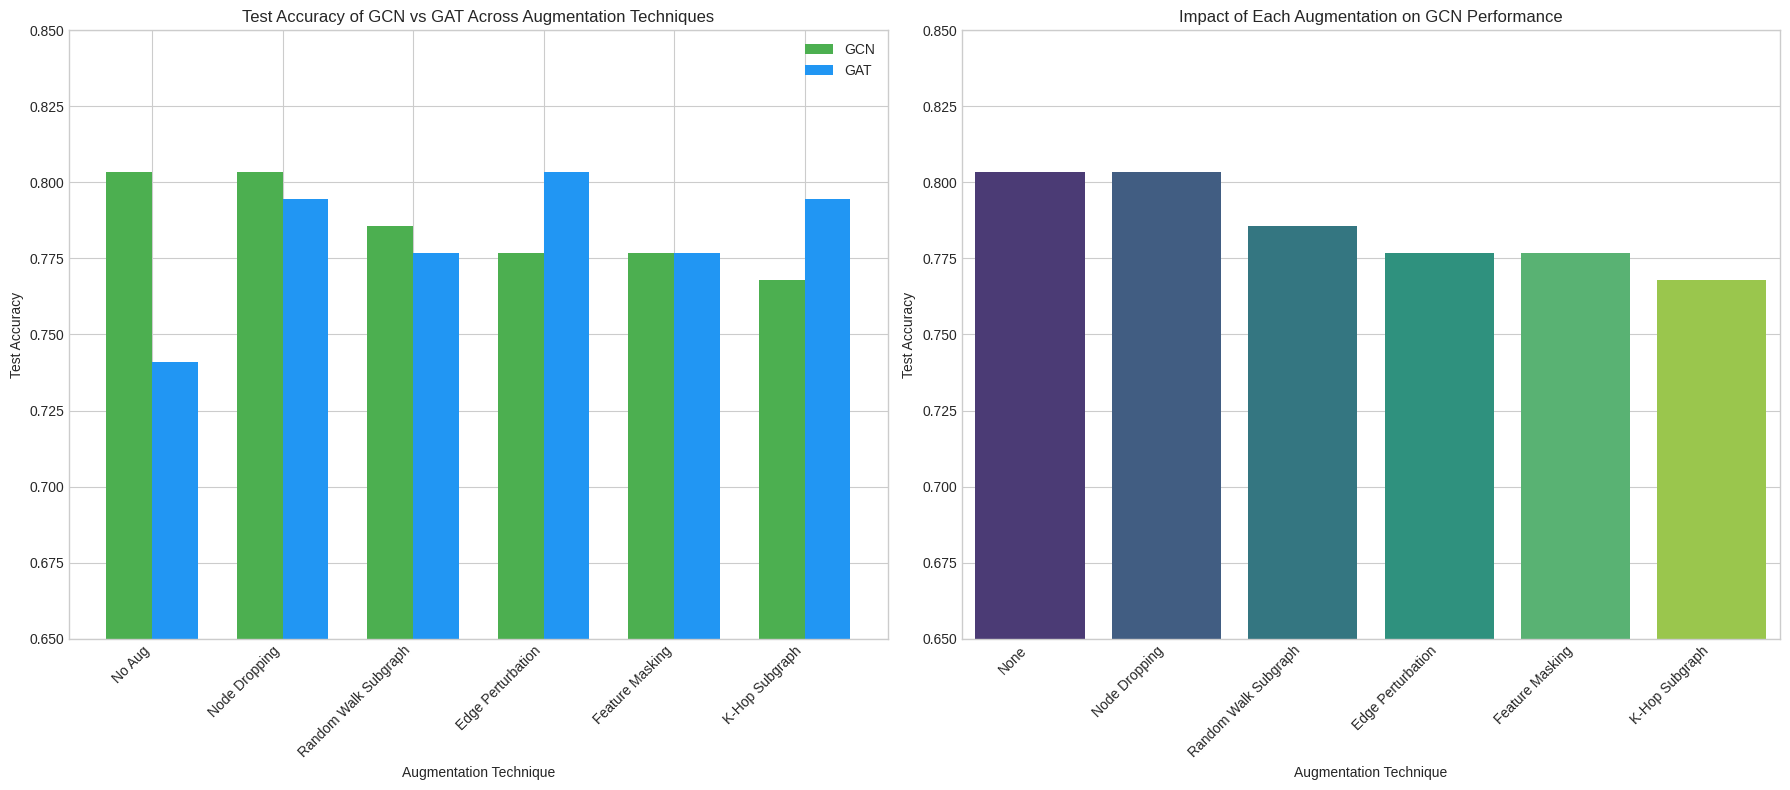

In [ ]:
# --- Final Results Summary and Plotting (Updated with Ensembles) ---
print("\n\n=== FINAL RESULTS SUMMARY ===")

# Add baseline Logistic Regression
all_results.insert(0, {
    'Model': 'Baseline (LogReg)',
    'Augmentation': 'N/A',
    'Test Accuracy': baseline_acc,
    'Test Macro F1': baseline_f1,
    'Parameters': 'N/A'
})

results_df = pd.DataFrame(all_results)
ensemble_df = pd.DataFrame(ensemble_results)
all_results_df = pd.concat([results_df, ensemble_df], ignore_index=True)

print(all_results_df.to_string(index=False))

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# === Plot 1: Grouped bar chart for GCN vs GAT vs Ensemble ===
gcn_df = all_results_df[all_results_df['Model'] == 'GCN'].reset_index(drop=True)
gat_df = all_results_df[all_results_df['Model'] == 'GAT'].reset_index(drop=True)
ens_df = all_results_df[all_results_df['Model'] == 'GCN+GAT Ensemble'].reset_index(drop=True)

x = np.arange(len(gcn_df))
width = 0.25

ax1.bar(x - width, gcn_df['Test Accuracy'], width, label='GCN', color='#4CAF50')
ax1.bar(x, gat_df['Test Accuracy'], width, label='GAT', color='#2196F3')
ax1.bar(x + width, ens_df['Test Accuracy'], width, label='Ensemble', color='#FF9800')

ax1.set_xticks(x)
ax1.set_xticklabels(['No Aug'] + list(aug_map.values()), rotation=45, ha='right')
ax1.set_xlabel('Augmentation Technique')
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Test Accuracy of GCN, GAT, and Ensemble Across Augmentations')
ax1.legend()
ax1.set_ylim(0.65, 0.90)

# === Plot 2: Detailed Ensemble performance ===
ens_performance = ens_df[['Augmentation', 'Test Accuracy']].copy()
ens_performance.loc[0, 'Augmentation'] = 'None'
sns.barplot(x='Augmentation', y='Test Accuracy', data=ens_performance, ax=ax2, palette='magma')

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_xlabel('Augmentation Technique')
ax2.set_ylabel('Test Accuracy')
ax2.set_title('Impact of Each Augmentation on Ensemble Performance')
ax2.set_ylim(0.65, 0.90)

plt.tight_layout()
plt.show()


## 8. Final Results & Takeaways

In [ ]:
# Ensure numeric conversion
all_results_df['Test Accuracy'] = pd.to_numeric(all_results_df['Test Accuracy'], errors='coerce')
all_results_df['Test Macro F1'] = pd.to_numeric(all_results_df['Test Macro F1'], errors='coerce')
all_results_df['Parameters'] = pd.to_numeric(all_results_df['Parameters'], errors='coerce')

# === Baseline ===
baseline_acc = all_results_df[all_results_df['Model'] == 'Baseline (LogReg)']['Test Accuracy'].iloc[0]
baseline_f1 = all_results_df[all_results_df['Model'] == 'Baseline (LogReg)']['Test Macro F1'].iloc[0]

# === GCN base ===
gcn_base = all_results_df[(all_results_df['Model'] == 'GCN') & (all_results_df['Augmentation'] == 'None')].iloc[0]
gcn_base_acc, gcn_base_f1, gcn_params = gcn_base['Test Accuracy'], gcn_base['Test Macro F1'], gcn_base['Parameters']

# === GAT base ===
gat_base = all_results_df[(all_results_df['Model'] == 'GAT') & (all_results_df['Augmentation'] == 'None')].iloc[0]
gat_base_acc, gat_base_f1, gat_params = gat_base['Test Accuracy'], gat_base['Test Macro F1'], gat_base['Parameters']

# === Ensemble base ===
ens_base = all_results_df[(all_results_df['Model'] == 'GCN+GAT Ensemble') & (all_results_df['Augmentation'] == 'None')].iloc[0]
ens_base_acc, ens_base_f1, ens_params = ens_base['Test Accuracy'], ens_base['Test Macro F1'], ens_base['Parameters']

# === Best models ===
best_gcn = all_results_df[all_results_df['Model'] == 'GCN'].sort_values('Test Accuracy', ascending=False).iloc[0]
best_gat = all_results_df[all_results_df['Model'] == 'GAT'].sort_values('Test Accuracy', ascending=False).iloc[0]
best_ens = all_results_df[all_results_df['Model'] == 'GCN+GAT Ensemble'].sort_values('Test Accuracy', ascending=False).iloc[0]

# Improvements
best_gcn_acc_improvement = best_gcn['Test Accuracy'] - baseline_acc
best_gcn_f1_improvement = best_gcn['Test Macro F1'] - baseline_f1
best_gat_acc_improvement = best_gat['Test Accuracy'] - baseline_acc
best_gat_f1_improvement = best_gat['Test Macro F1'] - baseline_f1
best_ens_acc_improvement = best_ens['Test Accuracy'] - baseline_acc
best_ens_f1_improvement = best_ens['Test Macro F1'] - baseline_f1

print(f"\n=== Key Findings ===")
print(f"• **All GNN-based models outperform the Logistic Regression baseline.**")
print(f"   – The best GCN achieves **+{best_gcn_acc_improvement:.3f} accuracy** and **+{best_gcn_f1_improvement:.3f} Macro F1** over the baseline (Augmentation: {best_gcn['Augmentation']}, Acc={best_gcn['Test Accuracy']:.4f}, F1={best_gcn['Test Macro F1']:.4f}).")
print(f"   – The best GAT achieves **+{best_gat_acc_improvement:.3f} accuracy** and **+{best_gat_f1_improvement:.3f} Macro F1** over the baseline (Augmentation: {best_gat['Augmentation']}, Acc={best_gat['Test Accuracy']:.4f}, F1={best_gat['Test Macro F1']:.4f}).")
print(f"   – The best Ensemble achieves **+{best_ens_acc_improvement:.3f} accuracy** and **+{best_ens_f1_improvement:.3f} Macro F1** over the baseline (Augmentation: {best_ens['Augmentation']}, Acc={best_ens['Test Accuracy']:.4f}, F1={best_ens['Test Macro F1']:.4f}).")

print(f"\n• **Model efficiency:** GCN is the most parameter-efficient with only {int(gcn_params)} params, compared to GAT’s {int(gat_params)} and Ensemble’s {int(ens_params)}. Despite its simplicity, augmented GCN matches or exceeds the more complex alternatives.")
print(f"• **Augmentation effects differ across models.** GCN benefits from augmentations like {best_gcn['Augmentation']}, while GAT performs inconsistently—sometimes improving (e.g., {best_gat['Augmentation']}) but also showing instability. The Ensemble generally provides balanced performance but doesn’t always surpass the best single model.")
print(f"• **Early stopping** continues to be effective, ensuring robust generalization without overfitting.")

print(f"\n=== Limitations & Improvements ===")
print(f"• GAT performance still fluctuates depending on augmentation, indicating sensitivity of attention mechanisms.")
print(f"• Ensemble methods improve robustness, but gains are modest compared to the best GCN. More diverse ensembling strategies (e.g., heterogeneous architectures or weighted voting) may yield stronger results.")
print(f"• The current models are optimized for homophilic graphs. Performance may degrade on heterophilic networks, requiring different architectures.")
print(f"• Exploring **advanced pooling layers** (SortPooling, DiffPool) and **architecture search** (depth, skip connections) could further improve results.")



=== Key Findings ===
• **All GNN-based models outperform the Logistic Regression baseline.**
   – The best GCN achieves **+0.089 accuracy** and **+0.216 Macro F1** over the baseline (Augmentation: None, Acc=0.8036, F1=0.7637).
   – The best GAT achieves **+0.089 accuracy** and **+0.220 Macro F1** over the baseline (Augmentation: Edge Perturbation, Acc=0.8036, F1=0.7677).
   – The best Ensemble achieves **+0.089 accuracy** and **+0.216 Macro F1** over the baseline (Augmentation: Random Walk Subgraph, Acc=0.8036, F1=0.7637).

• **Model efficiency:** GCN is the most parameter-efficient with only 4546 params, compared to GAT’s 36162 and Ensemble’s 40708. Despite its simplicity, augmented GCN matches or exceeds the more complex alternatives.
• **Augmentation effects differ across models.** GCN benefits from augmentations like None, while GAT performs inconsistently—sometimes improving (e.g., Edge Perturbation) but also showing instability. The Ensemble generally provides balanced performan